In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

import kagglehub

from time import perf_counter
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
except Exception as e:
    print("Installing xgboost...")
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBClassifier

In [2]:
import kagglehub
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path

random.seed(42)

source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350

os.makedirs(dest_dir, exist_ok=True)

class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)

kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train_view = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
dataset_eval_view  = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_test)

full_len = len(dataset_train_view)
train_size = int(0.7 * full_len)
val_size = int(0.2 * full_len)
test_size = full_len - train_size - val_size
train_subset, val_subset, test_subset = random_split(range(full_len), [train_size, val_size, test_size])

class IndexedSubset(torch.utils.data.Dataset):
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, i): return self.base_ds[self.indices[i]]

train_dataset = IndexedSubset(dataset_train_view, train_subset.indices)
val_dataset   = IndexedSubset(dataset_eval_view,  val_subset.indices)
test_dataset  = IndexedSubset(dataset_eval_view,  test_subset.indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset_train_view.classes
num_classes = len(class_names)

In [7]:
class_names = class_names
num_classes = num_classes

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention2D(nn.Module):

    def __init__(self, in_channels, d_model=256, num_heads=4, dropout=0.0):
        super().__init__()
        self.proj_in  = nn.Conv2d(in_channels, d_model, kernel_size=1)
        self.mha      = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                              dropout=dropout, batch_first=True)
        self.proj_out = nn.Conv2d(d_model, in_channels, kernel_size=1)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)
        self.ffn      = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        b, c, h, w = x.shape
        y = self.proj_in(x)
        y = y.flatten(2).transpose(1, 2)
        y = self.norm1(y)
        attn_out, _ = self.mha(y, y, y, need_weights=False)
        y = y + self.drop(attn_out)
        y2 = self.ffn(self.norm2(y))
        y = y + self.drop(y2)
        y = y.transpose(1, 2).view(b, -1, h, w)
        y = self.proj_out(y)
        return x + y

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.attn = SelfAttention2D(in_channels=128, d_model=256, num_heads=4, dropout=0.0)

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap_flat = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.attn(x)
        x = self.block4(x)
        feats = self.gap_flat(x)
        return feats

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.classifier(feats)
        return x

In [9]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [10]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from time import perf_counter

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5)

train_losses, val_losses = [], []
scaler = GradScaler()
total_train_t0 = perf_counter()
epoch_times = []

for epoch in range(num_epochs):
    t_epoch0 = perf_counter()

    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(enabled=(device.type=='cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type=='cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    epoch_time = perf_counter() - t_epoch0
    epoch_times.append(epoch_time)
    print(f"Epoch {epoch+1} time (s): {epoch_time:.2f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

TOTAL_TRAIN_TIME = perf_counter() - total_train_t0
AVG_EPOCH_TIME = (sum(epoch_times) / len(epoch_times)) if epoch_times else float('nan')
print(f"Total training time: {TOTAL_TRAIN_TIME:.2f} s")
print(f"Average epoch time: {AVG_EPOCH_TIME:.2f} s")


/tmp/ipykernel_19/2573809648.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_19/2573809648.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_19/2573809648.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):


Train Loss: 1.9623, Validation Loss: 1.6251
Epoch 1 time (s): 55.94
Epoch 2/50


Train Loss: 1.1283, Validation Loss: 0.9734
Epoch 2 time (s): 54.23
Epoch 3/50


Train Loss: 0.9234, Validation Loss: 0.6682
Epoch 3 time (s): 54.43
Epoch 4/50


Train Loss: 0.7827, Validation Loss: 0.8373
Epoch 4 time (s): 54.57
Epoch 5/50


Train Loss: 0.7130, Validation Loss: 0.4880
Epoch 5 time (s): 54.49
Epoch 6/50


Train Loss: 0.6558, Validation Loss: 0.5210
Epoch 6 time (s): 54.74
Epoch 7/50


Train Loss: 0.5864, Validation Loss: 0.3959
Epoch 7 time (s): 54.49
Epoch 8/50


Train Loss: 0.5661, Validation Loss: 0.3938
Epoch 8 time (s): 54.54
Epoch 9/50


Train Loss: 0.5250, Validation Loss: 0.4408
Epoch 9 time (s): 54.04
Epoch 10/50


Train Loss: 0.5104, Validation Loss: 0.5457
Epoch 10 time (s): 54.11
Epoch 11/50


Train Loss: 0.4901, Validation Loss: 0.3695
Epoch 11 time (s): 54.89
Epoch 12/50


Train Loss: 0.4721, Validation Loss: 0.4739
Epoch 12 time (s): 54.91
Epoch 13/50


Train Loss: 0.4551, Validation Loss: 0.4229
Epoch 13 time (s): 53.84
Epoch 14/50


Train Loss: 0.4345, Validation Loss: 0.3205
Epoch 14 time (s): 54.29
Epoch 15/50


Train Loss: 0.4049, Validation Loss: 0.4244
Epoch 15 time (s): 54.01
Epoch 16/50


Train Loss: 0.3699, Validation Loss: 0.3876
Epoch 16 time (s): 53.97
Epoch 17/50


Train Loss: 0.3898, Validation Loss: 0.2997
Epoch 17 time (s): 53.73
Epoch 18/50


Train Loss: 0.3688, Validation Loss: 0.2439
Epoch 18 time (s): 53.44
Epoch 19/50


Train Loss: 0.3582, Validation Loss: 0.1899
Epoch 19 time (s): 53.82
Epoch 20/50


Train Loss: 0.3574, Validation Loss: 0.2739
Epoch 20 time (s): 53.60
Epoch 21/50


Train Loss: 0.3742, Validation Loss: 0.2140
Epoch 21 time (s): 53.66
Epoch 22/50


Train Loss: 0.3423, Validation Loss: 0.3488
Epoch 22 time (s): 53.82
Epoch 23/50


Train Loss: 0.3434, Validation Loss: 0.2111
Epoch 23 time (s): 53.96
Epoch 24/50


Train Loss: 0.3296, Validation Loss: 0.2164
Epoch 24 time (s): 53.57
Early stopping triggered.
Total training time: 1301.06 s
Average epoch time: 54.21 s


In [11]:
model_save_path = "custom_cnn_model.pth"

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


In [12]:
model.eval()
def extract_features(dloader):
    X, y = [], []
    with torch.no_grad():
        for images, labels in tqdm(dloader, desc="Extracting feats", leave=False):
            images = images.to(device)
            feats = model.forward_features(images)
            X.append(feats.cpu().numpy())
            y.append(labels.numpy())
    return np.vstack(X), np.concatenate(y)

X_train, y_train = extract_features(train_loader)
X_val,   y_val   = extract_features(val_loader)
X_test,  y_test  = extract_features(test_loader)

print(X_train.shape, X_val.shape, X_test.shape)

(8820, 256) (2520, 256) (1260, 256)


In [13]:
classes = list(range(num_classes))
Y_train_ovr = label_binarize(y_train, classes=classes)
Y_val_ovr   = label_binarize(y_val,   classes=classes)
Y_test_ovr  = label_binarize(y_test,  classes=classes)

In [14]:
from time import perf_counter
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    infer_time_sum = 0.0
    num_images = 0
    for images, labels in test_loader:
        images = images.to(device)
        t0 = perf_counter()
        outputs = model(images)
        t1 = perf_counter()
        infer_time_sum += (t1 - t0)
        num_images += images.size(0)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

    TOTAL_INFER_TIME = infer_time_sum
    NUM_IMAGES = num_images
    AVG_INFER_PER_IMAGE = (infer_time_sum / num_images) if num_images > 0 else float('nan')

    print(f"Total test inference time: {TOTAL_INFER_TIME:.2f} s for {NUM_IMAGES} images")
    print(f"Average per-image inference time: {AVG_INFER_PER_IMAGE*1000:.2f} ms")

print("Baseline CNN — Test Classification Report:\n",
      classification_report(all_labels, all_preds, digits=4, target_names=class_names))


Total test inference time: 0.09 s for 1260 images
Average per-image inference time: 0.07 ms
Baseline CNN — Test Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab     0.9091    1.0000    0.9524        40
                                 Apple___Black_rot     0.9318    0.9318    0.9318        44
                                   Apple___healthy     0.8500    0.9444    0.8947        36
                               Blueberry___healthy     0.9655    1.0000    0.9825        28
          Cherry_(including_sour)___Powdery_mildew     0.9677    1.0000    0.9836        30
                 Cherry_(including_sour)___healthy     0.9268    1.0000    0.9620        38
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.8611    1.0000    0.9254        31
                       Corn_(maize)___Common_rust_     0.9459    1.0000    0.9722        35
               Corn_(maize)___North

In [15]:
def evaluate_classifier(name, clf, X_tr, y_tr, X_te, y_te):
    t0 = perf_counter(); clf.fit(X_tr, y_tr); t_fit = perf_counter() - t0
    t1 = perf_counter(); y_pred = clf.predict(X_te); t_pred = perf_counter() - t1

    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, labels=range(num_classes), average=None, zero_division=0)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_te, y_pred, average='macro', zero_division=0)
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(y_te, y_pred, average='micro', zero_division=0)
    cm = confusion_matrix(y_te, y_pred, labels=range(num_classes))

    print(f"\n=== {name} ===")
    print(f"Train time: {t_fit:.3f}s | Test time: {t_pred:.3f}s")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision/Recall/F1: {macro_p:.4f}/{macro_r:.4f}/{macro_f1:.4f}")
    print(f"Micro Precision/Recall/F1: {micro_p:.4f}/{micro_r:.4f}/{micro_f1:.4f}")
    print("Per-class Precision/Recall/F1:")
    for i, cls in enumerate(class_names):
        print(f"  {cls:>25s}: P={prec[i]:.4f} R={rec[i]:.4f} F1={f1[i]:.4f}")
    print("Confusion Matrix:\n", cm)
    return y_pred

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(C=1.0, kernel="rbf", probability=True))
])

knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

rf_clf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42)

xgb_clf = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    objective="multi:softprob", num_class=num_classes, tree_method="hist", n_jobs=-1, random_state=42
)

pred_svm = evaluate_classifier("SVM (RBF)", svm_clf, X_train, y_train, X_test, y_test)
pred_knn = evaluate_classifier("k-NN",      knn_clf, X_train, y_train, X_test, y_test)
pred_rf  = evaluate_classifier("RandomForest", rf_clf, X_train, y_train, X_test, y_test)
pred_xgb = evaluate_classifier("XGBoost",     xgb_clf, X_train, y_train, X_test, y_test)


=== SVM (RBF) ===
Train time: 13.300s | Test time: 1.606s
Accuracy: 0.9698
Macro Precision/Recall/F1: 0.9705/0.9700/0.9693
Micro Precision/Recall/F1: 0.9698/0.9698/0.9698
Per-class Precision/Recall/F1:
         Apple___Apple_scab: P=0.9302 R=1.0000 F1=0.9639
          Apple___Black_rot: P=1.0000 R=0.9773 F1=0.9885
            Apple___healthy: P=0.9474 R=1.0000 F1=0.9730
        Blueberry___healthy: P=1.0000 R=1.0000 F1=1.0000
  Cherry_(including_sour)___Powdery_mildew: P=0.9677 R=1.0000 F1=0.9836
  Cherry_(including_sour)___healthy: P=1.0000 R=1.0000 F1=1.0000
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: P=0.8611 R=1.0000 F1=0.9254
  Corn_(maize)___Common_rust_: P=0.9722 R=1.0000 F1=0.9859
  Corn_(maize)___Northern_Leaf_Blight: P=1.0000 R=0.8387 F1=0.9123
     Corn_(maize)___healthy: P=1.0000 R=0.9655 F1=0.9825
          Grape___Black_rot: P=0.9189 R=0.9714 F1=0.9444
  Grape___Esca_(Black_Measles): P=1.0000 R=0.9474 F1=0.9730
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): P=0.

In [16]:
def proba(clf, X):
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)
    if isinstance(clf, Pipeline):
        last = clf.steps[-1][1]
        if hasattr(last, "predict_proba"):
            return clf.predict_proba(X)
        if hasattr(last, "decision_function"):
            df = clf.decision_function(X)
            import numpy as np
            if df.ndim == 1:
                df = np.vstack([-df, df]).T
            exps = np.exp(df - df.max(axis=1, keepdims=True))
            return exps / exps.sum(axis=1, keepdims=True)
    raise ValueError("Classifier does not provide probabilities/decision function.")

def roc_auc_report(name, clf, X, Y_ovr, class_names):
    P = proba(clf, X)
    per_class_auc = []
    for i in range(Y_ovr.shape[1]):
        fpr, tpr, _ = roc_curve(Y_ovr[:, i], P[:, i])
        auc_i = roc_auc_score(Y_ovr[:, i], P[:, i])
        per_class_auc.append(auc_i)
    macro_auc = float(np.mean(per_class_auc))
    micro_auc = roc_auc_score(Y_ovr, P, average='micro', multi_class='ovr')
    print(f"\n{name} — AUCs")
    for i, cls in enumerate(class_names):
        print(f"  AUC[{cls}]: {per_class_auc[i]:.4f}")
    print(f"  Macro-AUC: {macro_auc:.4f} | Micro-AUC: {micro_auc:.4f}")

roc_auc_report("SVM (RBF)",    svm_clf, X_test, Y_test_ovr, class_names)
roc_auc_report("k-NN",         knn_clf, X_test, Y_test_ovr, class_names)
roc_auc_report("RandomForest", rf_clf,  X_test, Y_test_ovr, class_names)
roc_auc_report("XGBoost",      xgb_clf, X_test, Y_test_ovr, class_names)


SVM (RBF) — AUCs
  AUC[Apple___Apple_scab]: 1.0000
  AUC[Apple___Black_rot]: 0.9999
  AUC[Apple___healthy]: 1.0000
  AUC[Blueberry___healthy]: 1.0000
  AUC[Cherry_(including_sour)___Powdery_mildew]: 1.0000
  AUC[Cherry_(including_sour)___healthy]: 1.0000
  AUC[Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot]: 0.9993
  AUC[Corn_(maize)___Common_rust_]: 1.0000
  AUC[Corn_(maize)___Northern_Leaf_Blight]: 0.9991
  AUC[Corn_(maize)___healthy]: 1.0000
  AUC[Grape___Black_rot]: 0.9998
  AUC[Grape___Esca_(Black_Measles)]: 1.0000
  AUC[Grape___Leaf_blight_(Isariopsis_Leaf_Spot)]: 0.9999
  AUC[Grape___healthy]: 0.9998
  AUC[Orange___Haunglongbing_(Citrus_greening)]: 0.9998
  AUC[Peach___Bacterial_spot]: 1.0000
  AUC[Peach___healthy]: 1.0000
  AUC[Pepper,_bell___Bacterial_spot]: 1.0000
  AUC[Pepper,_bell___healthy]: 1.0000
  AUC[Potato___Early_blight]: 1.0000
  AUC[Potato___Late_blight]: 1.0000
  AUC[Raspberry___healthy]: 1.0000
  AUC[Soybean___healthy]: 0.9995
  AUC[Squash___Powdery_mildew]:

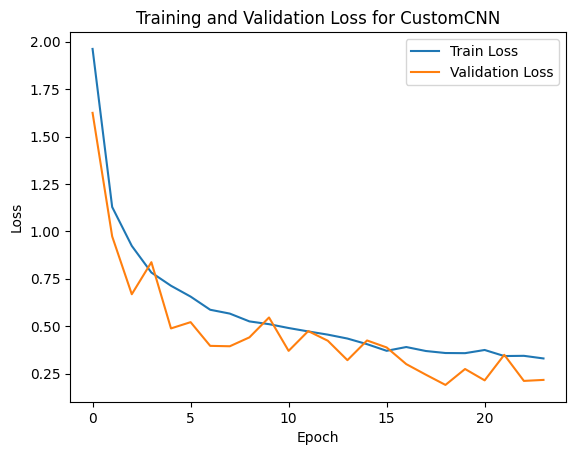

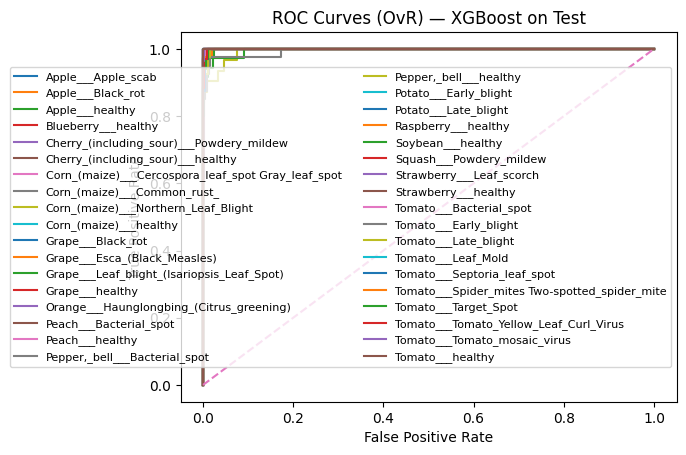

In [17]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

try:
    P = proba(xgb_clf, X_test)
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(Y_test_ovr[:, i], P[:, i])
        plt.plot(fpr, tpr, label=f"{cls}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OvR) — XGBoost on Test")
    plt.legend(ncol=2, fontsize=8)
    plt.show()
except Exception as e:
    print("ROC plot skipped:", e)

In [18]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-2nq51ska
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-2nq51ska
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

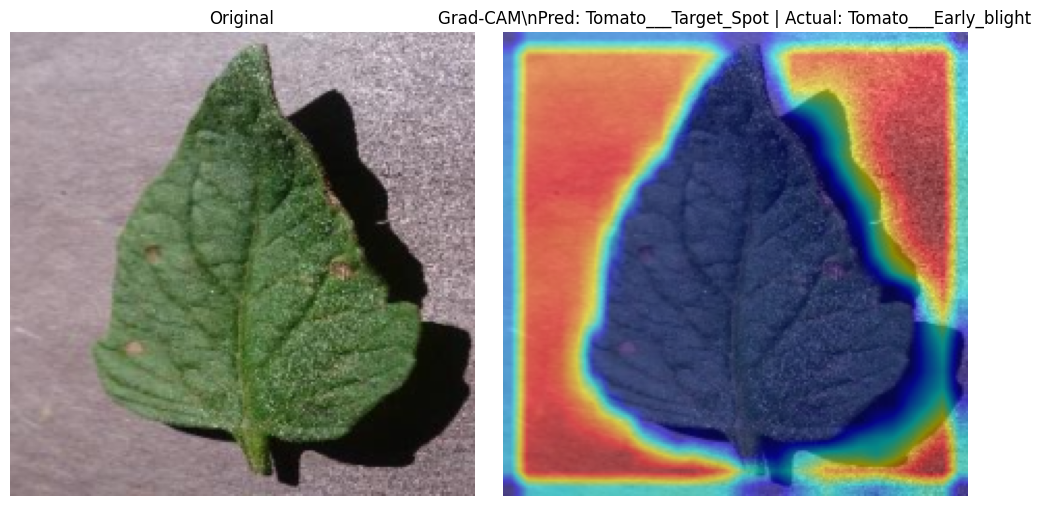

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
std  = np.array([0.5, 0.5, 0.5], dtype=np.float32)


def pick_target_layers(m):
    if hasattr(m, "layer4"):
        return [m.layer4[-1]]
    if hasattr(m, "block4") and isinstance(m.block4[0], torch.nn.Conv2d):
        return [m.block4[0]]
    if hasattr(m, "features"):
        convs = [mod for mod in m.features.modules() if isinstance(mod, torch.nn.Conv2d)]
        if convs:
            return [convs[-1]]
    if hasattr(m, "features"):
        convs = [mod for mod in m.features if isinstance(mod, torch.nn.Conv2d)]
        if convs:
            return [convs[-1]]
    convs = [mod for mod in m.modules() if isinstance(mod, torch.nn.Conv2d)]
    if not convs:
        raise RuntimeError("Could not find a Conv2d layer for Grad-CAM.")
    return [convs[-1]]

model.eval().to(device)
target_layers = pick_target_layers(model)

sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

img_np = sample_image[0].detach().cpu().permute(1, 2, 0).numpy().astype(np.float32)
original_image_np = np.clip(img_np * std + mean, 0.0, 1.0)

cam = GradCAM(model=model, target_layers=target_layers)
with torch.no_grad():
    outputs = model(sample_image)
predicted_class = int(outputs.argmax(dim=1).item())

targets = [ClassifierOutputTarget(predicted_class)]
grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]

result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(original_image_np); plt.axis('off')
plt.subplot(1,2,2); 
plt.title(f"Grad-CAM\\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result); plt.axis('off')
plt.tight_layout(); plt.show()

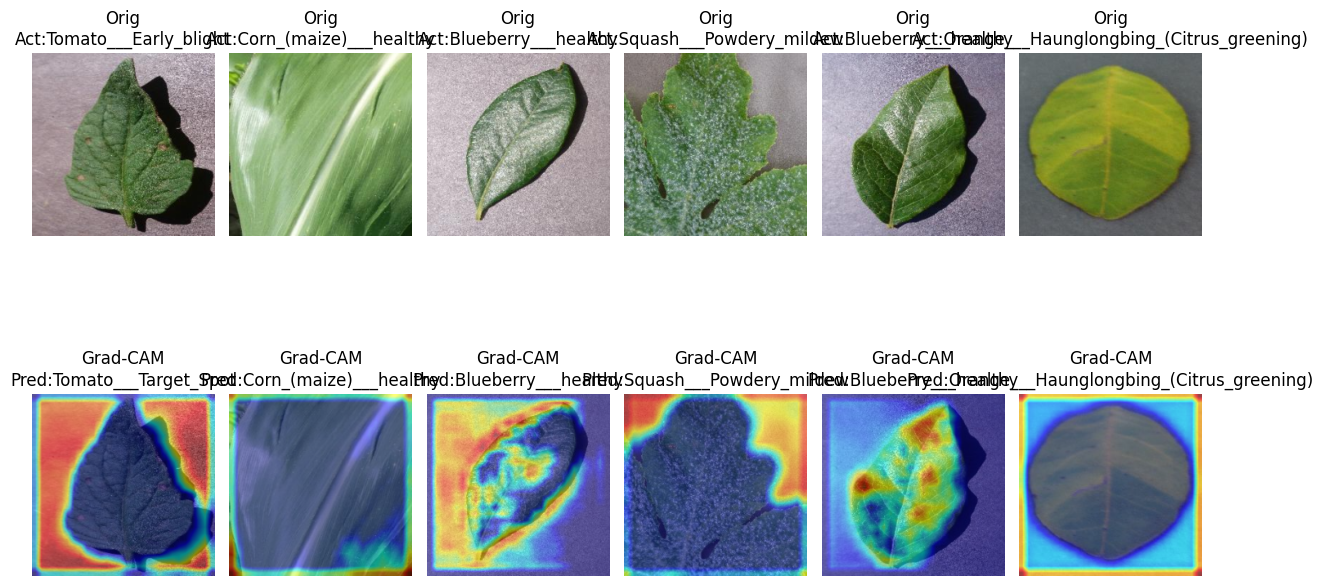

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
std  = np.array([0.5, 0.5, 0.5], dtype=np.float32)

target_layers = [model.block4[0]]

model.eval().to(device)

cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(12, 8))
for idx in range(6):
    sample_image, label = test_dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    img_np = sample_image[0].detach().cpu().permute(1, 2, 0).numpy().astype(np.float32)
    original_image_np = np.clip(img_np * std + mean, 0.0, 1.0)

    with torch.no_grad():
        outputs = model(sample_image)
    predicted_class = int(outputs.argmax(dim=1).item())

    targets = [ClassifierOutputTarget(predicted_class)]
    grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]

    result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

    plt.subplot(2, 6, idx+1)
    plt.imshow(original_image_np)
    plt.title(f"Orig\nAct:{class_names[label]}")
    plt.axis('off')

    plt.subplot(2, 6, idx+1+6)
    plt.imshow(result)
    plt.title(f"Grad-CAM\nPred:{class_names[predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()